## Step 1: Import the necessary libraries

In [1]:
import os
import shutil
import tarfile
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
import pandas as pd
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objects as go
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

## Step 2: Load the dataset

In [2]:
# Get the current working directory
current_folder = os.getcwd()

dataset = tf.keras.utils.get_file(
	fname ="aclImdb.tar.gz",
	origin ="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz",
	cache_dir= current_folder,
	extract = True)

84125825/84125825 [==============================] - 18s 0us/step


In [3]:
dataset_path = os.path.dirname(dataset)
# Check the dataset
os.listdir(dataset_path)

['aclImdb.tar.gz', 'aclImdb']

In [4]:
# Dataset directory
dataset_dir = os.path.join(dataset_path, 'aclImdb')

# Check the Dataset directory
os.listdir(dataset_dir)

['imdbEr.txt', 'test', 'README', 'train', 'imdb.vocab']

In [5]:
# Chech train dataset folder
train_dir = os.path.join(dataset_dir,'train')
os.listdir(train_dir)

['urls_unsup.txt',
 'urls_neg.txt',
 'unsup',
 'urls_pos.txt',
 'pos',
 'unsupBow.feat',
 'neg',
 'labeledBow.feat']

In [6]:
# Read the files in train
for file in os.listdir(train_dir):
	file_path = os.path.join(train_dir, file)
	# Check if it's a file (not a directory)
	if os.path.isfile(file_path):
		with open(file_path, 'r', encoding='utf-8') as f:
			first_value = f.readline().strip()
			print(f"{file}: {first_value}")
	else:
		print(f"{file}: {file_path}")

urls_unsup.txt: http://www.imdb.com/title/tt0018515/usercomments
urls_neg.txt: http://www.imdb.com/title/tt0064354/usercomments
unsup: /content/datasets/aclImdb/train/unsup
urls_pos.txt: http://www.imdb.com/title/tt0453418/usercomments
pos: /content/datasets/aclImdb/train/pos
unsupBow.feat: 0 0:8 1:6 3:5 4:2 5:1 7:1 8:5 9:2 10:1 11:2 13:3 16:1 17:1 18:1 19:1 22:3 24:1 26:3 28:1 30:1 31:1 35:2 36:1 39:2 40:1 41:2 46:2 47:1 48:1 52:1 63:1 67:1 68:1 74:1 81:1 83:1 87:1 104:1 105:1 112:1 117:1 131:1 151:1 155:1 170:1 198:1 225:1 226:1 288:2 291:1 320:1 331:1 342:1 364:1 374:1 384:2 385:1 407:1 437:1 441:1 465:1 468:1 470:1 519:1 595:1 615:1 650:1 692:1 851:1 937:1 940:1 1100:1 1264:1 1297:1 1317:1 1514:1 1728:1 1793:1 1948:1 2088:1 2257:1 2358:1 2584:2 2645:1 2735:1 3050:1 4297:1 5385:1 5858:1 7382:1 7767:1 7773:1 9306:1 10413:1 11881:1 15907:1 18613:1 18877:1 25479:1
neg: /content/datasets/aclImdb/train/neg
labeledBow.feat: 9 0:9 1:1 2:4 3:4 4:6 5:4 6:2 7:2 8:4 10:4 12:2 26:1 27:1 28:1 29

In [7]:
# load the movie review and convert into panda's data frame with their respective sentiment
def load_dataset(directory):
	data = {"sentence": [], "sentiment": []}
	for file_name in os.listdir(directory):
		print(file_name)
		if file_name == 'pos':
			positive_dir = os.path.join(directory, file_name)
			for text_file in os.listdir(positive_dir):
				text = os.path.join(positive_dir, text_file)
				with open(text, "r", encoding="utf-8") as f:
					data["sentence"].append(f.read())
					data["sentiment"].append(1)
		elif file_name == 'neg':
			negative_dir = os.path.join(directory, file_name)
			for text_file in os.listdir(negative_dir):
				text = os.path.join(negative_dir, text_file)
				with open(text, "r", encoding="utf-8") as f:
					data["sentence"].append(f.read())
					data["sentiment"].append(0)

	return pd.DataFrame.from_dict(data)

In [8]:
# Load the dataset from the train_dir
train_df = load_dataset(train_dir)
print(train_df.head())

urls_unsup.txt
urls_neg.txt
unsup
urls_pos.txt
pos
unsupBow.feat
neg
labeledBow.feat
                                            sentence  sentiment
0  I saw "El Mar" yesterday and thought it to be ...          1
1  The House of the Spirits is a gripping tale of...          1
2  Before watching this film I had heard a lot ab...          1
3  The world at war is one of the best documentar...          1
4  Watching the commercials for this movie, I was...          1


In [9]:
test_dir = os.path.join(dataset_dir,'test')

# Load the dataset from the test_dir
test_df = load_dataset(test_dir)
print(test_df.head())

urls_neg.txt
urls_pos.txt
pos
neg
labeledBow.feat
                                            sentence  sentiment
0  True stories make the best stories don't they?...          1
1  Betty is an understudy for the lead in a produ...          1
2  Frank Sinatra did so many excellent things in ...          1
3  I have seen this movie three times. Going back...          1
4  One cannot help but admire Mike Judge for his ...          1


## Step 3: Preprocessing

In [10]:
sentiment_counts = train_df['sentiment'].value_counts()

fig =px.bar(x= {0:'Negative',1:'Positive'},
			y= sentiment_counts.values,
			color=sentiment_counts.index,
			color_discrete_sequence = px.colors.qualitative.Dark24,
			title='<b>Sentiments Counts')

fig.update_layout(title='Sentiments Counts',
				xaxis_title='Sentiment',
				yaxis_title='Counts',
				template='plotly_dark')

# Show the bar chart
fig.show()
# pyo.plot(fig, filename = 'Sentiments Counts.html', auto_open = True)

In [11]:
# Text cleaning
def text_cleaning(text):
	soup = BeautifulSoup(text, "html.parser")
	text = re.sub(r'\[[^]]*\]', '', soup.get_text())
	pattern = r"[^a-zA-Z0-9\s,']"
	text = re.sub(pattern, '', text)
	return text

In [12]:
# Train dataset
train_df['Cleaned_sentence'] = train_df['sentence'].apply(text_cleaning).tolist()
# Test dataset
test_df['Cleaned_sentence'] = test_df['sentence'].apply(text_cleaning)

<ipython-input-11-844cfd4d7427>:3: MarkupResemblesLocatorWarning:

The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.

<ipython-input-11-844cfd4d7427>:3: MarkupResemblesLocatorWarning:

The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.



In [13]:
# Function to generate word cloud
def generate_wordcloud(text,Title):
	all_text = " ".join(text)
	wordcloud = WordCloud(width=800,
						height=400,
						stopwords=set(STOPWORDS),
						background_color='black').generate(all_text)
	plt.figure(figsize=(10, 5))
	plt.imshow(wordcloud, interpolation='bilinear')
	plt.axis("off")
	plt.title(Title)
	plt.show()

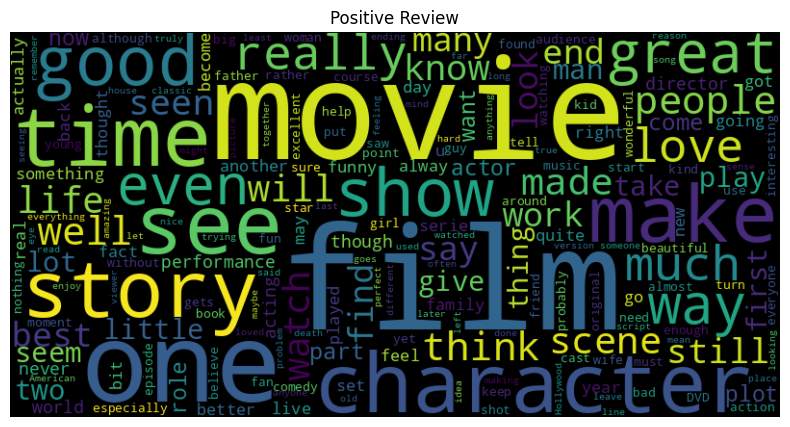

In [14]:
# positive reviews
positive = train_df[train_df['sentiment']==1]['Cleaned_sentence'].tolist()
generate_wordcloud(positive,'Positive Review')

In [15]:
# Training data
#Reviews = "[CLS] " +train_df['Cleaned_sentence'] + "[SEP]"
Reviews = train_df['Cleaned_sentence']
Target = train_df['sentiment']

# Test data
#test_reviews = "[CLS] " +test_df['Cleaned_sentence'] + "[SEP]"
test_reviews = test_df['Cleaned_sentence']
test_targets = test_df['sentiment']

In [16]:
# Split the data into training and validation sets
x_val, x_test, y_val, y_test = train_test_split(test_reviews,
													test_targets,
													test_size=0.5,
													stratify = test_targets)

## Step 4: Tokenization & Encoding

In [17]:
#Tokenize and encode the data using the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning:

`clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884



In [18]:
max_len= 128
# Tokenize and encode the sentences
X_train_encoded = tokenizer.batch_encode_plus(Reviews.tolist(),
											padding=True,
											truncation=True,
											max_length = max_len,
											return_tensors='tf')

X_val_encoded = tokenizer.batch_encode_plus(x_val.tolist(),
											padding=True,
											truncation=True,
											max_length = max_len,
											return_tensors='tf')

X_test_encoded = tokenizer.batch_encode_plus(x_test.tolist(),
											padding=True,
											truncation=True,
											max_length = max_len,
											return_tensors='tf')

In [19]:
# check encoded dataset
k = 0
print('Training Comments -->>',Reviews[k])
print('\nInput Ids -->>\n',X_train_encoded['input_ids'][k])
print('\nDecoded Ids -->>\n',tokenizer.decode(X_train_encoded['input_ids'][k]))
print('\nAttention Mask -->>\n',X_train_encoded['attention_mask'][k])
print('\nLabels -->>',Target[k])

Training Comments -->> I saw El Mar yesterday and thought it to be a great movie It starts with a childhood episode in the life of the 3 main characters Ramallo, Manuel Tur, and Francisca After that we jump about 10 years to an hospital where the 3 friends meet againReligion, sickness, love, violence and sexuality rage throughout the movie creating and intense and tensionfilled movieI see people complaining about the film being too gory and i think they missed the point of the story It's a violent, intense and sad story People are expected to suffer To cry To get hurt To bleed And i think that what the film shows, isn't done for pure shockvalue or presented in a distasteful way I know that some people like their films clean, even those with violence in it But sometimes, a movie needs to make you feel unconfortable to work This is one of those movies And a great movie it isThe only fault i found was that there were 3 or 4 moments were some plot details weren't 100 clear, and only after 

## Step 5: Build the classification model

In [31]:
# Intialize the model
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
# Compile the model with an appropriate optimizer, loss function, and metrics
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [33]:
# Train the model
history = model.fit(
	[X_train_encoded['input_ids'], X_train_encoded['token_type_ids'], X_train_encoded['attention_mask']],
	Target,
	validation_data=(
	[X_val_encoded['input_ids'], X_val_encoded['token_type_ids'], X_val_encoded['attention_mask']],y_val),
	batch_size=32,
	epochs=3
)

Epoch 1/3
782/782 [==============================] - 798s 979ms/step - loss: 0.3493 - accuracy: 0.8390 - val_loss: 0.3081 - val_accuracy: 0.8746
Epoch 2/3
782/782 [==============================] - 761s 973ms/step - loss: 0.1972 - accuracy: 0.9234 - val_loss: 0.3253 - val_accuracy: 0.8835
Epoch 3/3
782/782 [==============================] - 762s 974ms/step - loss: 0.1091 - accuracy: 0.9616 - val_loss: 0.3409 - val_accuracy: 0.8807


## Step 6:Evaluate the model

In [34]:
#Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(
	[X_test_encoded['input_ids'], X_test_encoded['token_type_ids'], X_test_encoded['attention_mask']],
	y_test
)
print(f'Test loss: {test_loss}, Test accuracy: {test_accuracy}')

391/391 [==============================] - 110s 281ms/step - loss: 0.3410 - accuracy: 0.8843
Test loss: 0.3410070836544037, Test accuracy: 0.8843200206756592


In [35]:
# Path to current directory
path = './'

# Save tokenizer
tokenizer.save_pretrained(path +'/Tokenizer')

# Save model
model.save_pretrained(path +'/Model')

In [37]:
# Load tokenizer
bert_tokenizer = BertTokenizer.from_pretrained(path +'/Tokenizer')

# Load model
bert_model = TFBertForSequenceClassification.from_pretrained(path +'/Model')

Some layers from the model checkpoint at .//Model were not used when initializing TFBertForSequenceClassification: ['dropout_113']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at .//Model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [38]:
# Predict the sentiment of the test dataset
pred = bert_model.predict(
	[X_test_encoded['input_ids'], X_test_encoded['token_type_ids'], X_test_encoded['attention_mask']])

# pred is of type TFSequenceClassifierOutput
logits = pred.logits

# Use argmax along the appropriate axis to get the predicted labels
pred_labels = tf.argmax(logits, axis=1)

# Convert the predicted labels to a NumPy array
pred_labels = pred_labels.numpy()

label = {
	1: 'positive',
	0: 'Negative'
}

# Map the predicted labels to their corresponding strings using the label dictionary
pred_labels = [label[i] for i in pred_labels]
Actual = [label[i] for i in y_test]

print('Predicted Label :', pred_labels[:10])
print('Actual Label :', Actual[:10])

391/391 [==============================] - 112s 280ms/step
Predicted Label : ['positive', 'Negative', 'positive', 'positive', 'Negative', 'positive', 'positive', 'Negative', 'positive', 'Negative']
Actual Label : ['positive', 'Negative', 'Negative', 'Negative', 'Negative', 'positive', 'Negative', 'Negative', 'positive', 'Negative']


In [39]:
print("Classification Report: \n", classification_report(Actual, pred_labels))


Classification Report: 
               precision    recall  f1-score   support

    Negative       0.92      0.84      0.88      6250
    positive       0.86      0.93      0.89      6250

    accuracy                           0.88     12500
   macro avg       0.89      0.88      0.88     12500
weighted avg       0.89      0.88      0.88     12500



## Step 7: Prediction with user inputs

In [40]:
def Get_sentiment(Review, Tokenizer=bert_tokenizer, Model=bert_model):
	# Convert Review to a list if it's not already a list
	if not isinstance(Review, list):
		Review = [Review]

	Input_ids, Token_type_ids, Attention_mask = Tokenizer.batch_encode_plus(Review,
																			padding=True,
																			truncation=True,
																			max_length=128,
																			return_tensors='tf').values()
	prediction = Model.predict([Input_ids, Token_type_ids, Attention_mask])

	# Use argmax along the appropriate axis to get the predicted labels
	pred_labels = tf.argmax(prediction.logits, axis=1)

	# Convert the TensorFlow tensor to a NumPy array and then to a list to get the predicted sentiment labels
	pred_labels = [label[i] for i in pred_labels.numpy().tolist()]
	return pred_labels

In [41]:
Review ='''Bahubali is a blockbuster Indian movie that was released in 2015.
It is the first part of a two-part epic saga that tells the story of a legendary hero who fights for his kingdom and his love.
The movie has received rave reviews from critics and audiences alike for its stunning visuals,
spectacular action scenes, and captivating storyline.'''
Get_sentiment(Review)

1/1 [==============================] - 3s 3s/step


['positive']